In [87]:
import numpy as np
import matplotlib.pyplot as plt

from src.Optimizer import BayesianOptimization
from src.Utils import rosenbrock, rbf_kernel

In [88]:


limits = [(-2,2), (-2,3)]
opt = BayesianOptimization(kernel=rbf_kernel, 
                           optimization_function=rosenbrock,
                           limits=limits)


n_warmup = 1
opt.optimize(N_warmup=n_warmup,N_optimize=30)

{'x': array([ 9.39392862e-05, -8.10375634e-06]), 'y': 8.890260349730582e-09}

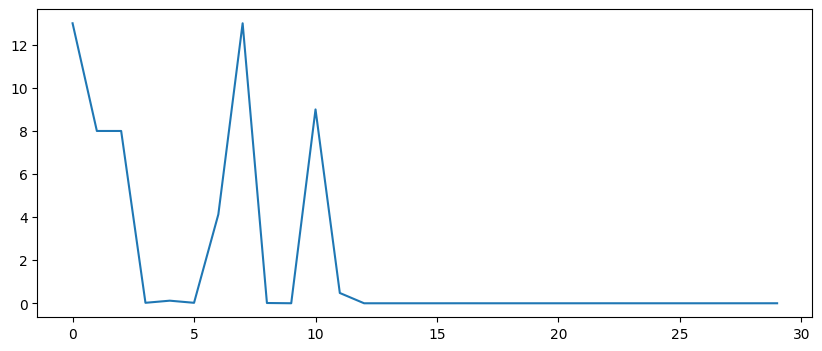

In [89]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot([_ for _ in range(len(opt.gaussian_process.sample_values[n_warmup:]))],opt.gaussian_process.sample_values[n_warmup:])
#plt.savefig('out.png',dpi=200)
plt.show()

In [90]:
np.all(np.linalg.eigvals(opt.gaussian_process.covariance_matrix.get_matrix()) >= 0)

False